In [1]:
import numpy as np
import matplotlib.pyplot as plt
from src.data_util import load_preprocess_examples
from src.evaluation import DAP_SAP_MAP_kde, hist_AP, plot_SAP_MAP

import tensorflow as tf

from sklearn.model_selection import train_test_split
import glob
import json
import os

# os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import seaborn as sns
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

2024-06-19 08:55:41.265980: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-19 08:55:41.916479: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


**Load training and validation data**

In [21]:
dap_factor = 180
sap_factor = 180
map_factor = 160

X, y, clrs_pig = load_preprocess_examples(
    "/data/PulHypStudie_Check_npz/",
    ["P_{0:02d}_PulHyp".format(i) for i in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]],
    sap=True,
    get_pig=True,
    shuffle=False,
    norm_eit="block",
    quality_check=False,
)

y[:, 0] = y[:, 0] / dap_factor  # dap normalization
y[:, 1] = y[:, 1] / sap_factor  # sap normalization
y[:, 2] = y[:, 2] / map_factor  # map normalization

Loading data from /data/PulHypStudie_Check_npz/P_01_PulHyp
Loading data from /data/PulHypStudie_Check_npz/P_02_PulHyp
Loading data from /data/PulHypStudie_Check_npz/P_03_PulHyp
Loading data from /data/PulHypStudie_Check_npz/P_04_PulHyp
Loading data from /data/PulHypStudie_Check_npz/P_05_PulHyp
Loading data from /data/PulHypStudie_Check_npz/P_06_PulHyp
Loading data from /data/PulHypStudie_Check_npz/P_07_PulHyp
Loading data from /data/PulHypStudie_Check_npz/P_08_PulHyp
Loading data from /data/PulHypStudie_Check_npz/P_09_PulHyp
Loading data from /data/PulHypStudie_Check_npz/P_10_PulHyp


In [22]:
print(X.shape, y.shape, clrs_pig.shape)

(84526, 64, 1024, 1) (84526, 3) (84526, 3)


In [23]:
X_train, X_valid, y_train, y_valid, clrs_train, clrs_valid = train_test_split(
    X, y, clrs_pig, test_size=0.1, random_state=42, shuffle=True
)

In [24]:
print(
    X_train.shape,
    X_valid.shape,
    y_train.shape,
    y_valid.shape,
    clrs_train.shape,
    clrs_valid.shape,
)

(76073, 64, 1024, 1) (8453, 64, 1024, 1) (76073, 3) (8453, 3) (76073, 3) (8453, 3)


**PCA**

In [25]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(
    X_valid.reshape(X_valid.shape[0], X_valid.shape[1] * X_valid.shape[2])
)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

In [26]:
pigs_int = [int(c[0][4:6]) for c in clrs_valid]

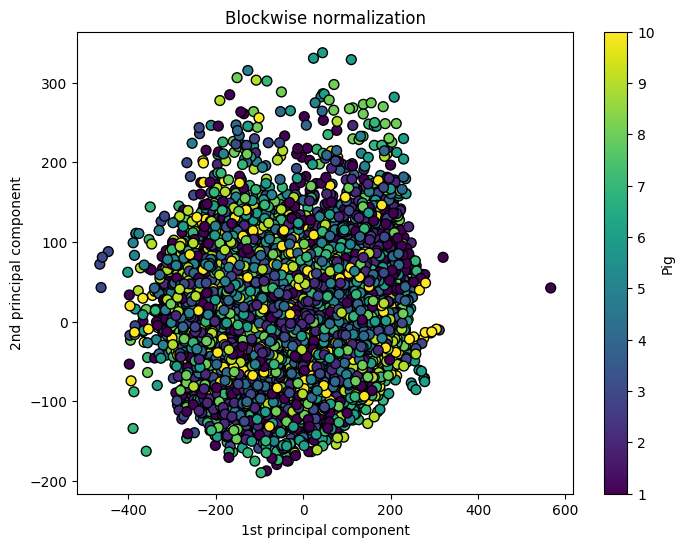

In [27]:
plt.figure(figsize=(8, 6))
plt.title("Blockwise normalization")
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=pigs_int, edgecolor="k", s=50)
c_bar = plt.colorbar()
c_bar.set_label("Pig")
plt.xlabel("1st principal component")
plt.ylabel("2nd principal component")
plt.show()

**Loat test data**

In [8]:
X_test, y_true, clrs_pig_test = load_preprocess_examples(
    "/data/PulHyp_and_SVV_npz/",
    ["P_09_PulHyp"],
    sap=True,
    get_pig=True,
    shuffle=False,
    norm_eit="block",
)
y_test = np.zeros(y_true.shape)
y_test[:, 0] = y_true[:, 0] / dap_factor  # dap normalization
y_test[:, 1] = y_true[:, 1] / sap_factor  # sap normalization
y_test[:, 2] = y_true[:, 2] / map_factor  # map normalization

Loading data from /data/PulHyp_and_SVV_npz/P_09_PulHyp


In [10]:
print(X_test.shape, y_test.shape, clrs_pig_test.shape)

(8263, 64, 1024, 1) (8263, 3) (8263, 3)


**Create model**

In [55]:
m_idx

1

In [264]:
# https://www.tensorflow.org/tutorials/images/cnn

# |--------------------------------------------------------- HPT -------------------------------------------------------|
optimizer = "adam"
# | model  1: epochs = 30, batch_size = 64, kernels = 3, filters = [8, 4, 2], opt = adam, loss = mse|
# | model  2: epochs = 30, batch_size = 64, kernels = 4, filters = [8, 4, 2], opt = adam, loss = mse|
# | model  3: epochs = 30, batch_size = 64, kernels = 5, filters = [8, 4, 2], opt = adam, loss = mse|
# | model  4: epochs = 30, batch_size = 64, kernels = 6, filters = [8, 4, 2], opt = adam, loss = mse|
# | model  5: epochs = 30, batch_size = 64, kernels = 7, filters = [8, 4, 2], opt = adam, loss = mse|
# | model  6: epochs = 30, batch_size = 64, kernels = 9, filters = [8, 4, 2], opt = adam, loss = mse|
# kernels = 9
# | model  7: epochs = 30, batch_size = 64, kernels = 9, filters = [8, 4, 2], opt = adam, loss = mae|
loss_fct = "mae"
# | model  8: epochs = 30, batch_size = 64, kernels = 3, filters = [8, 4, 2], opt = adam, loss = mae|
# | model  9: epochs = 30, batch_size = 64, kernels = 4, filters = [8, 4, 4, 2], opt = adam, loss = mae|
# | model 10: epochs = 30, batch_size = 64, kernels = 3, filters = [8, 4, 2], opt = adam, loss = mae|
# | model 11: epochs = 30, batch_size = 64, kernels = 3, filters = [8, 4, 2], opt = adam, loss = mae|

kernels = 3
filters = [8, 4, 2]
# | model 12: epochs = 30, batch_size = 32, kernels = 3, filters = [8, 4, 2], opt = adam, loss = mae|
# | model 13: epochs = 30, batch_size = 16, kernels = 3, filters = [8, 4, 2], opt = adam, loss = mae|
# | model 14: epochs = 30, batch_size = 8, kernels = 3, filters = [8, 4, 2], opt = adam, loss = mae|
# | model 15: epochs = 30, batch_size = 4, kernels = 3, filters = [8, 4, 2], opt = adam, loss = mae|
# | model 16: epochs = 30, batch_size = 2, kernels = 3, filters = [8, 4, 2], opt = adam, loss = mae|
batch_size = 2
epochs = 30


def AP_model(input_shape, kernel, filters, output_shape=3):
    model_input = tf.keras.layers.Input(shape=input_shape)
    x = model_input

    for fltr in filters:
        x = tf.keras.layers.Conv2D(filters=fltr, kernel_size=kernel, activation="relu")(
            x
        )
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.MaxPooling2D((2, 2))(x)

    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(64, activation="relu")(x)
    model_output = tf.keras.layers.Dense(output_shape)(x)

    return tf.keras.models.Model(model_input, model_output)


model = AP_model(input_shape=(64, 1024, 1), kernel=kernels, filters=filters)
model.compile(optimizer=optimizer, loss=loss_fct, metrics=["accuracy"])
model.summary()

Model: "functional_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_19 (InputLayer)     │ (None, 64, 1024, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_61 (Conv2D)              │ (None, 62, 1022, 8)    │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_60          │ (None, 62, 1022, 8)    │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_60 (MaxPooling2D) │ (None, 31, 511, 8)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_62 (Conv2D)              │ (None, 29, 509, 4)     │           292 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_61          │ (None, 29, 509, 4)     │            16 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_61 (MaxPooling2D) │ (None, 14, 254, 4)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_63 (Conv2D)              │ (None, 12, 252, 2)     │            74 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_62          │ (None, 12, 252, 2)     │             8 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_62 (MaxPooling2D) │ (None, 6, 126, 2)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_18 (Flatten)            │ (None, 1512)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 64)             │        96,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 97,529 (380.97 KB)

 Trainable params: 97,501 (380.86 KB)

 Non-trainable params: 28 (112.00 B)

In [265]:
history = model.fit(
    X_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_valid, y_valid),
)

Epoch 1/30
  101/33094 ━━━━━━━━━━━━━━━━━━━━ 50s 2ms/step - accuracy: 0.3756 - loss: 1.0086      

I0000 00:00:1718182466.877597 2433383 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_multiply_reduce_fusion_1', 268 bytes spill stores, 268 bytes spill loads



33094/33094 ━━━━━━━━━━━━━━━━━━━━ 89s 3ms/step - accuracy: 0.6514 - loss: 0.0685 - val_accuracy: 0.5791 - val_loss: 0.0383
Epoch 2/30
33094/33094 ━━━━━━━━━━━━━━━━━━━━ 79s 2ms/step - accuracy: 0.6901 - loss: 0.0366 - val_accuracy: 0.7137 - val_loss: 0.0359
Epoch 3/30
33094/33094 ━━━━━━━━━━━━━━━━━━━━ 86s 3ms/step - accuracy: 0.7036 - loss: 0.0348 - val_accuracy: 0.8322 - val_loss: 0.0306
Epoch 4/30
33094/33094 ━━━━━━━━━━━━━━━━━━━━ 89s 3ms/step - accuracy: 0.8186 - loss: 0.0305 - val_accuracy: 0.8031 - val_loss: 0.0296
Epoch 5/30
33094/33094 ━━━━━━━━━━━━━━━━━━━━ 89s 3ms/step - accuracy: 0.8255 - loss: 0.0300 - val_accuracy: 0.8035 - val_loss: 0.0278
Epoch 6/30
33094/33094 ━━━━━━━━━━━━━━━━━━━━ 85s 3ms/step - accuracy: 0.8273 - loss: 0.0289 - val_accuracy: 0.8125 - val_loss: 0.0336
Epoch 7/30
33094/33094 ━━━━━━━━━━━━━━━━━━━━ 80s 2ms/step - accuracy: 0.8294 - loss: 0.0284 - val_accuracy: 0.8155 - val_loss: 0.0264
Epoch 8/30
33094/33094 ━━━━━━━━━━━━━━━━━━━━ 86s 3ms/step - accuracy: 0.8256 - lo

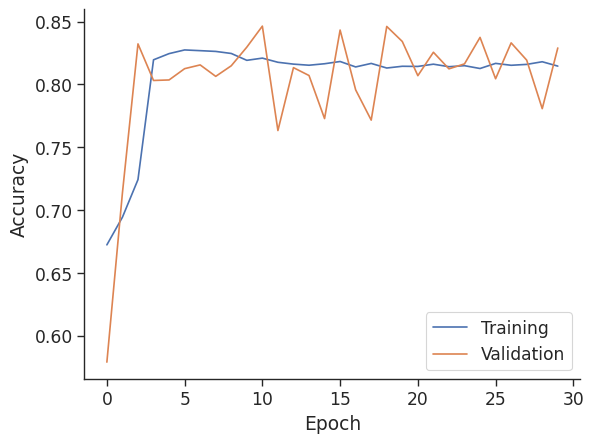

In [266]:
plt.plot(history.history["accuracy"], label="Training")
plt.plot(history.history["val_accuracy"], label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.show()

**Predict test data**

- `y_pred` ...  Predicted data in true AP value range
- `y_true` ...  True AP data in true value range
- `y_test` ...  True AP data in scaled value range

In [267]:
y_pred = model.predict(X_test)
y_pred[:, 0] = y_pred[:, 0] * dap_factor  # dap normalization
y_pred[:, 1] = y_pred[:, 1] * sap_factor  # sap normalization
y_pred[:, 2] = y_pred[:, 2] * map_factor  # map normalization

259/259 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [268]:
m_idx = len(glob.glob("models/model/*.h5")) + 1
print("Model:", m_idx)
np.savez(
    f"models/history/model_{m_idx}.npz",
    accuracy=history.history["accuracy"],
    loss=history.history["loss"],
    val_accuracy=history.history["val_accuracy"],
    val_loss=history.history["val_loss"],
)

Model: 16


Test data loss, accuracy, and least-squares solution $$y = mx + n$$ for SAP, MAP and DAP predictions.

259/259 - 1s - 5ms/step - accuracy: 0.4291 - loss: 0.0712


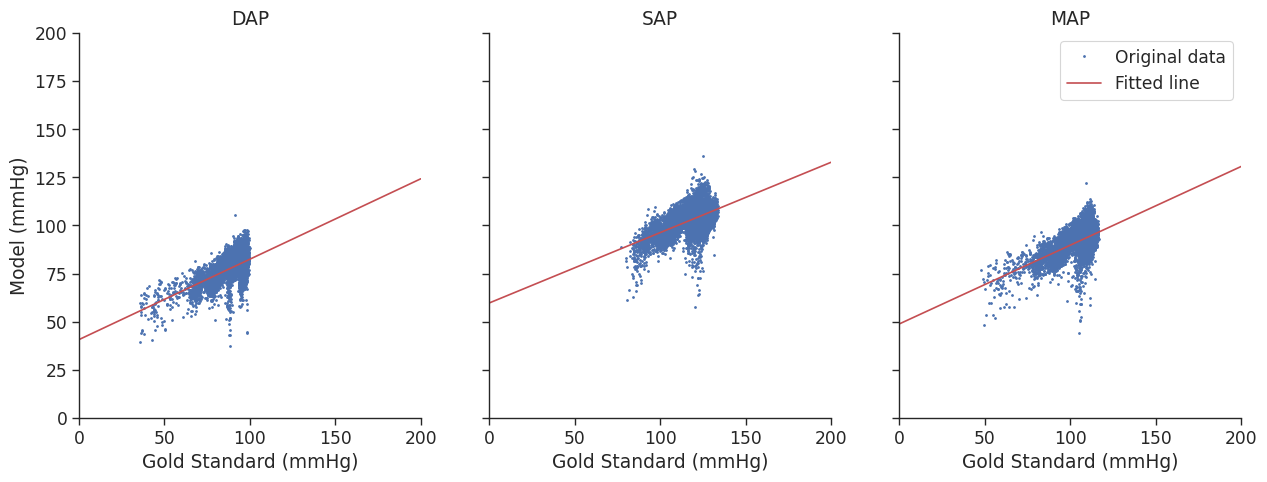

In [269]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)

accs_dct = {
    "model": m_idx,
    "test_loss": test_loss,
    "test_acc": test_acc,
}

lst_sqrs = ["DAP_m", "DAP_n", "SAP_m", "SAP_n", "MAP_m", "MAP_n"]
fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
ax[0].set_ylabel("Model (mmHg)")
for ap in range(y_pred.shape[1]):
    y = y_true[:, ap]
    x = y_pred[:, ap]
    A = np.vstack([y, np.ones(len(y))]).T
    m, n = np.linalg.lstsq(A, x, rcond=None)[0]

    accs_dct[lst_sqrs[ap * 2]] = m
    accs_dct[lst_sqrs[ap * 2 + 1]] = n

    x_f = np.linspace(0, 200)
    ax[ap].set_xlabel("Gold Standard (mmHg)")
    ax[ap].set_xlim(0, 200)
    ax[ap].set_ylim(0, 200)
    ax[ap].set_title(lst_sqrs[ap * 2][:3])
    ax[ap].plot(y, x, "o", label="Original data", markersize=1)
    ax[ap].plot(x_f, m * x_f + n, "r", label="Fitted line")
plt.legend()
plt.show()

with open(f"models/accs/acc_{m_idx}.json", "w") as json_file:
    json.dump(accs_dct, json_file)

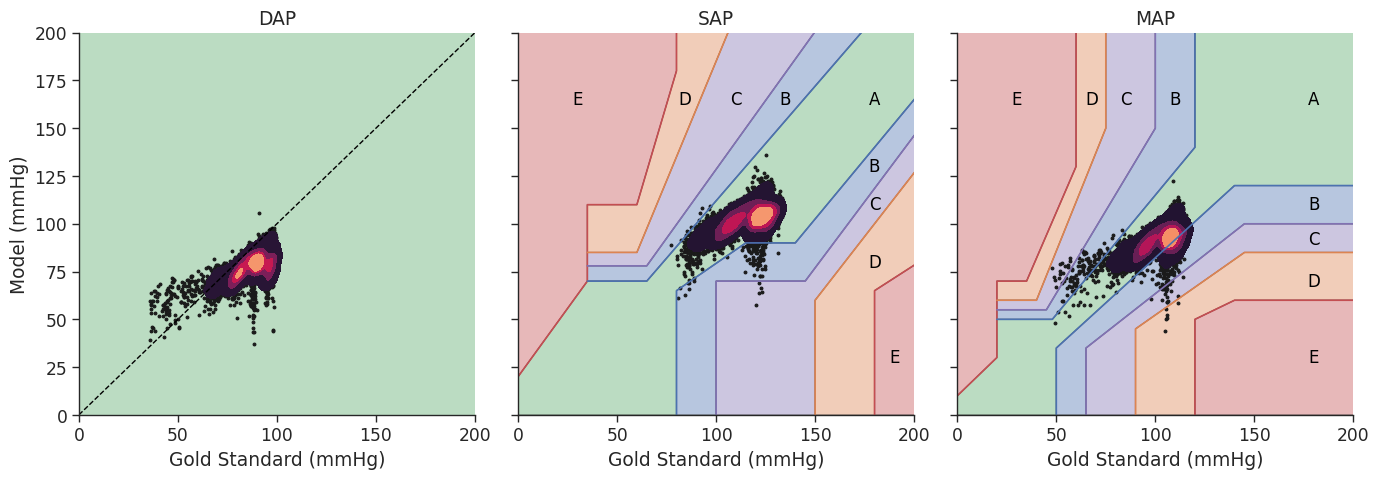

In [270]:
DAP_SAP_MAP_kde(y_pred, y_true)

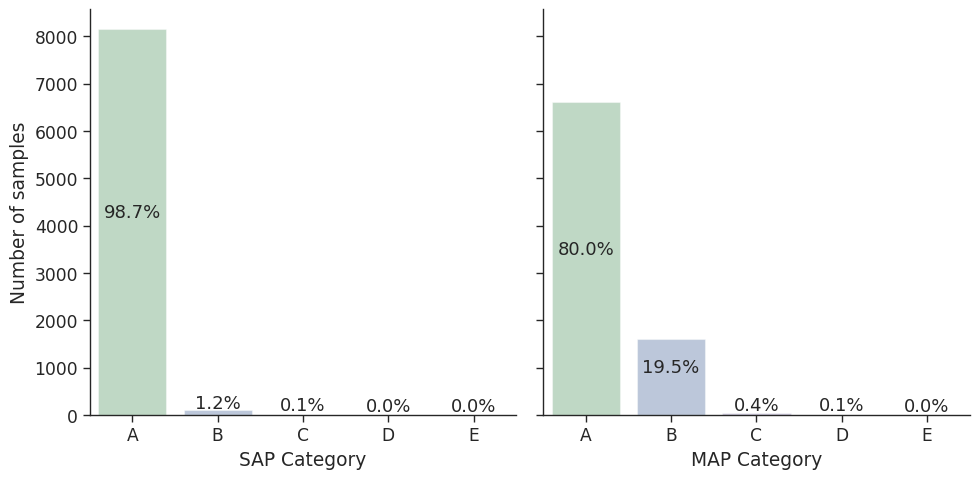

In [271]:
df_SAP = hist_AP(y_pred, y_true, AP="SAP")
df_MAP = hist_AP(y_pred, y_true, AP="MAP")

plot_SAP_MAP(df_SAP, df_MAP)

In [272]:
df_SAP.to_csv(f"models/hists/df_SAP_{m_idx}.csv", index=False)
df_MAP.to_csv(f"models/hists/df_MAP_{m_idx}.csv", index=False)

In [273]:
acc_measure = dict(Model=list(), Error_val=list(), Error=list())

data_append = []
Errors_names = ["DAP", "SAP", "MAP"]

for pred, true in zip(y_pred, y_true):
    err = pred - true
    for e in range(3):
        data_append.append(dict(Model=m_idx, Error_val=err[e], Error=Errors_names[e]))
for item in data_append:
    for key, value in item.items():
        acc_measure[key].append(value)

acc_measure_df = pd.DataFrame(acc_measure).dropna()
acc_measure_df.to_csv(f"models/boxen/sgl_box_m_{m_idx}.csv", index=False)
acc_measure_df

,Model,Error_val,Error
0,16,-5.075490,DAP
1,16,-15.860967,SAP
2,16,-10.581018,MAP
3,16,-8.018049,DAP
4,16,-8.391385,SAP
...,...,...,...
24784,16,-18.980508,SAP
24785,16,-19.592979,MAP
24786,16,-6.807195,DAP
24787,16,-9.230871,SAP


Text(0, 0.5, 'Error (%)')

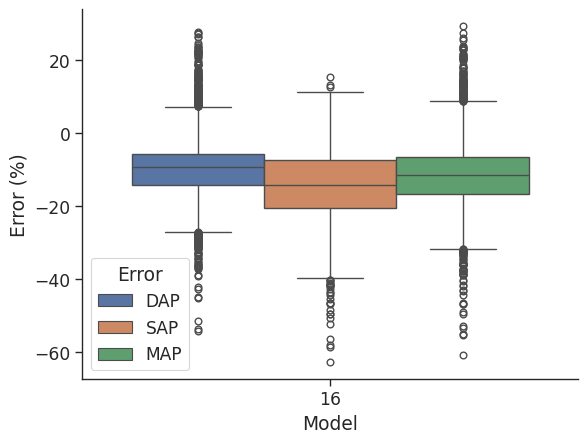

In [274]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
sns.set_context(context="paper", font_scale=1.4)

sns.boxplot(x="Model", y="Error_val", data=acc_measure_df, hue="Error", showfliers=True)
plt.ylabel("Error (%)")
# plt.xlabel("Model Iteration")

In [278]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
sns.set_context(context="paper", font_scale=1.4)

combined_df = pd.concat(
    [pd.read_csv(f_csvs) for f_csvs in np.sort(glob.glob("models/boxen/*.csv"))],
    ignore_index=True,
)
combined_df = pd.DataFrame(combined_df)

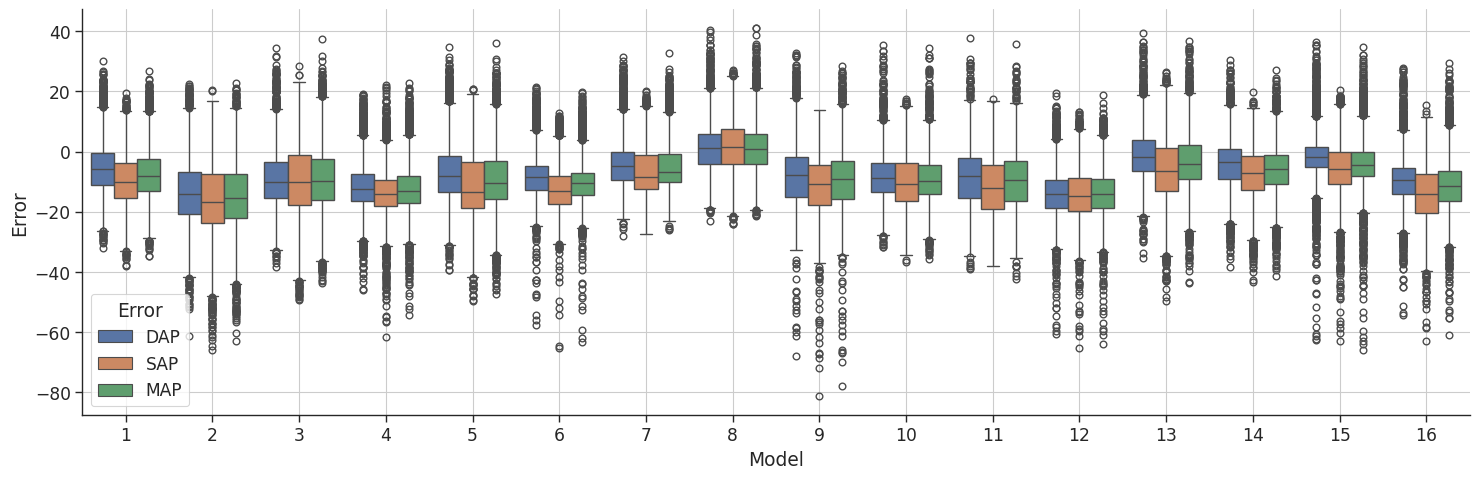

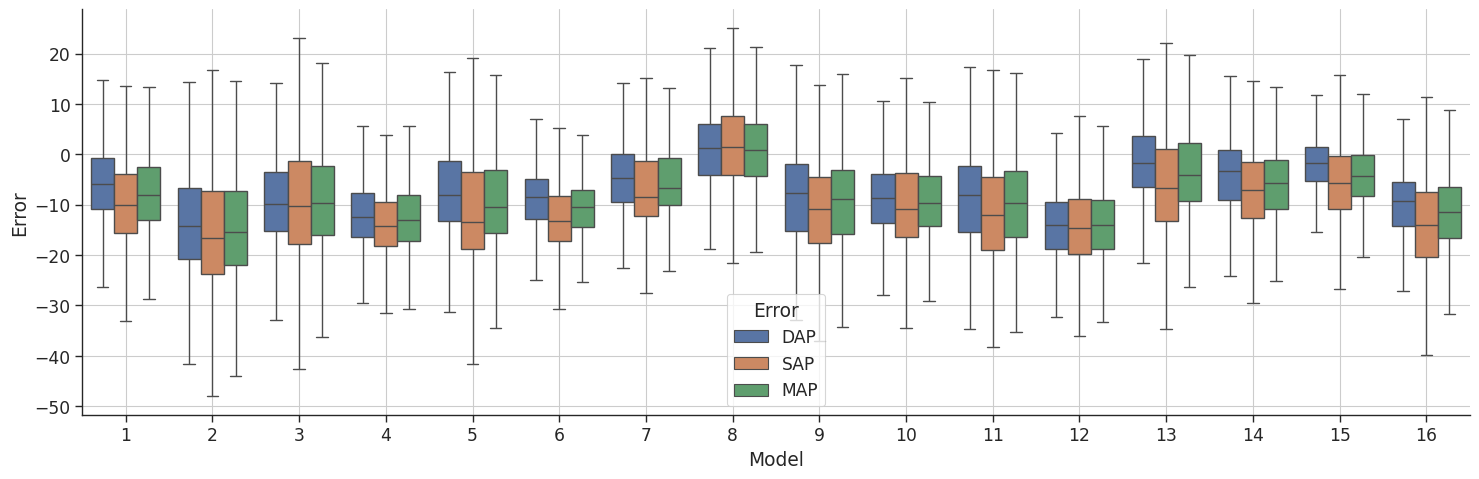

In [280]:
plt.figure(figsize=(15, 5))
sns.boxplot(
    x="Model",
    y="Error_val",
    data=combined_df,
    hue="Error",
    showfliers=True,
)  #  violinplot: , split=True
plt.ylabel("Error")
plt.grid(True)
plt.tight_layout()
# plt.xlim([-0.5, 25])
plt.show()
plt.figure(figsize=(15, 5))
sns.boxplot(
    x="Model",
    y="Error_val",
    data=combined_df,
    hue="Error",
    showfliers=False,
)  #  violinplot: , split=True
plt.ylabel("Error")
plt.grid(True)
plt.tight_layout()
# plt.xlim([-0.5, 25])
plt.show()

In [276]:
# Wanna save the weights?
model.save_weights(f"models/model/model_{m_idx}.weights.h5")

___